In [ ]:
!pip3 install pyro-ppl

     |████████████████████████████████| 634kB 5.6MB/s 


In [ ]:
# Part1
# basic parametric density estimation
# obs: real 1d vector of shape (N,)
# N: positive integer

function normal_density_estimation(obs, N)
  loc ~ normal(0.0, 1.0)  # mu, sigma
  inverse_scale ~ gamma(3.0, 2.0)  # alpha = 3.0, beta = 2.0
  for i in 1:N:
    data[i] ~ observe(normal(loc, 1/inverse_scale), obs[i])

OrderedDict([('_INPUT', {'name': '_INPUT', 'type': 'args', 'args': (None,), 'kwargs': {'size': 1}}), ('loc', {'type': 'sample', 'name': 'loc', 'fn': Normal(loc: 0.0, scale: 1.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(-0.1334), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None, 'unscaled_log_prob': tensor(-0.9278), 'log_prob': tensor(-0.9278), 'log_prob_sum': tensor(-0.9278)}), ('inverse_scale', {'type': 'sample', 'name': 'inverse_scale', 'fn': Gamma(concentration: 3.0, rate: 2.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(1.7075), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None, 'unscaled_log_prob': tensor(-0.9587), 'log_prob': tensor(-0.9587), 'log_prob_sum': tensor(-0.9587)}), ('data_plate', {'type': 'sample', 'name': 'data_plate', 'fn': <pyro.poutine.subsample_messenger._Subsample object at 0x7f79db541650>

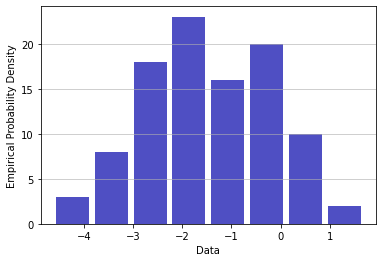

In [ ]:
import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)

def normal_density_estimation(data, size=1):
  loc = pyro.sample("loc", pyro.distributions.Normal(0.0, 1.0))
  inverse_scale = pyro.sample("inverse_scale", pyro.distributions.Gamma(3.0, 2.0))
  with pyro.plate("data_plate", size=size):
    obs = pyro.sample("data", pyro.distributions.Normal(loc, 1.0/inverse_scale), obs=data)
  return obs

# model is fully generative here, generate some data
data = normal_density_estimation(None, size=100)

# plot the histogram
n, bins, patches = plt.hist(x=data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Data')
plt.ylabel('Empirical Probability Density')

# trace
static_trace = pyro.poutine.trace(normal_density_estimation).get_trace(None, size=1)
static_trace.compute_log_prob()
print(static_trace.nodes)
print({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in static_trace.nodes.items()
    if props['type'] == 'sample'
})

In [ ]:
# Part 2
# continuous, nonstationary hidden markov model
# obs: real, 2d tensor of shape (N, T)
# N: positive integer
# T: positive integer

function continuous_hmm(obs, N, T)
loc ~ normal(0.0, 1.0)
log_scale ~ normal(0.0, 1.0)
obs_scale ~ gamma(2.0, 2.0)
for n in 1:N:
  x[n, 0] ~ normal(loc, exp(log_scale))
  for t in 1:T:
    x[n, t] ~ normal(loc + x[n, t - 1], exp(log_scale))
    y[n, t] ~ observe(normal(x[n, t], obs_scale), obs[n, t])

In [ ]:
import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)

def continuous_hmm(data, N, T):
  loc = pyro.sample("loc", pyro.distributions.Normal(0.0, 1.0))
  log_scale = pyro.sample("log_scale", pyro.distributions.Normal(0.0, 1.0))
  obs_scale = pyro.sample("obs_scale", pyro.distributions.Gamma(2.0, 2.0))
  retval = torch.empty((T, N))

  with pyro.plate("data_plate", size=N):
    x = pyro.sample("x_0", pyro.distributions.Normal(loc, torch.exp(log_scale)))

    for t in pyro.markov(range(1, T)):
      x = pyro.sample(f"x_{t}", pyro.distributions.Normal(loc+x, torch.exp(log_scale)))
      y = pyro.sample(f"y_{t}", pyro.distributions.Normal(x, obs_scale), obs=None if data==None else data[:, t])
      retval[t-1] = y
  return  retval

# model is fully generative here, generate some data
data = continuous_hmm(None, 100, 10)

# trace
static_trace = pyro.poutine.trace(continuous_hmm).get_trace(None, 2, 2)
static_trace.compute_log_prob()
print(static_trace.nodes)

# print the trace, from https://willcrichton.net/notes/probabilistic-programming-under-the-hood/
print({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in static_trace.nodes.items()
    if props['type'] == 'sample'
})


OrderedDict([('_INPUT', {'name': '_INPUT', 'type': 'args', 'args': (None, 2, 2), 'kwargs': {}}), ('loc', {'type': 'sample', 'name': 'loc', 'fn': Normal(loc: 0.0, scale: 1.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.7377), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None, 'unscaled_log_prob': tensor(-1.1911), 'log_prob': tensor(-1.1911), 'log_prob_sum': tensor(-1.1911)}), ('log_scale', {'type': 'sample', 'name': 'log_scale', 'fn': Normal(loc: 0.0, scale: 1.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.3728), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None, 'unscaled_log_prob': tensor(-0.9884), 'log_prob': tensor(-0.9884), 'log_prob_sum': tensor(-0.9884)}), ('obs_scale', {'type': 'sample', 'name': 'obs_scale', 'fn': Gamma(concentration: 2.0, rate: 2.0), 'is_observed': False, 'args': (), 'kwargs': {}, 'value'

In [ ]:
# part 3
# discrete observation temporal switching model
# obs: positive integer 2d tensor of shape (T, N)
# model1: arbitrary callable with signature (t :: float) :: float
# model2: arbitrary callable with signature (t :: float) :: float
# NOTE: both model1 and model2 outputs must be positive floats as they 
# NOTE: correspond to a rate parameter of a poisson distribution
# T: positive integer
# N: positive integer

function discrete_obs_switching_model(obs, model1, model2, T, N)
  log_scale ~ normal(0.0, 1.0)
  z[0] ~ normal(0.0, exp(log_scale))
  for t in 1:T:
    z[t] ~ normal(z[t-1], 1.0)
    p[t] = invlogit(z[t])
    for n in 1:N:
      switch[t, n] ~ bernoulli(p[t])
      if switch:
        y[t, n] = model1(t)
      else:
        y[t, n] = model2(t)
      x[t, n] ~ observe(poisson(y[t, n]), obs[t, n])

In [ ]:
import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt

pyro.set_rng_seed(101)

def model1(t):
  return 2

def  model2(t):
  return 3 #pyro.sample("m2", pyro.distributions.Normal(10.0, 1.0))

def discrete_obs_switching_model(data, model1, model2, T, N):
  log_scale = pyro.sample("loc", pyro.distributions.Normal(0.0, 1.0))
  z = pyro.sample("z_0", pyro.distributions.Normal(0.0, torch.exp(log_scale)))
  retval = torch.empty((T, N))

  for t in pyro.markov(range(1, T)):
    z = pyro.sample(f"z_{t}", pyro.distributions.Normal(z, 1.0))
    #invlogit
    p = torch.exp(z)/(1+torch.exp(z))

    with pyro.plate("data_plate", size=N):
      switch = pyro.sample(f"switch_{t}", pyro.distributions.Bernoulli(p))
      #if switch ==0:
      #  y = model1(t)
      #else:
      #  y = model2(t)
      y = torch.mul(switch, model1(t)) + torch.mul((1-switch), model2(t))
      #with pyro.poutine.mask(mask = (switch == 1)):
      #  y=model1(t)
      #with pyro.poutine.mask(mask = (switch == 0)):
      #  y=model2(t)
      x = pyro.sample(f"x_{t}", pyro.distributions.Poisson(y), obs=None if data==None else data[:, t])
      retval[t-1] = x
  return  retval

# model is fully generative here, generate some data
data = discrete_obs_switching_model(None, model1, model2, 100, 10)
print(data)

# trace
static_trace = discrete_obs_switching_model(None, model1, model2, 2, 2)
print(static_trace.nodes)

# print the trace, from https://willcrichton.net/notes/probabilistic-programming-under-the-hood/
print({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in static_trace.nodes.items()
    if props['type'] == 'sample'
})

tensor([[2.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00,
         4.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00],
        [1.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         6.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00],
        [3.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00, 5.0000e+00, 0.0000e+00,
         4.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00],
        [6.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
         3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00],
        [0.0000e+00, 1.0000e+00, 5.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00,
         1.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00],
        [3.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
         4.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00],
        [3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
         2.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00],
        [3.0000e+00, 3.0000

AttributeError: ignored